In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

## Travel time prediction

In [2]:
data = pd.read_csv('../dataPreprocessing/data/data.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636659 entries, 0 to 1636658
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vehicle_id         1636659 non-null  int64  
 1   line_id            1636659 non-null  int64  
 2   datetime           1636659 non-null  object 
 3   station_id         1636659 non-null  int64  
 4   vehicle_type       1636659 non-null  float64
 5   sequence_id        1636659 non-null  object 
 6   order              1636659 non-null  int64  
 7   line_label         1636659 non-null  object 
 8   datetime_diff      1636659 non-null  float64
 9   outlier            1636659 non-null  int64  
 10  hour               1636659 non-null  int64  
 11  quarter            1636659 non-null  int64  
 12  weekday            1636659 non-null  int64  
 13  service_class      1636659 non-null  int64  
 14  Temperature        1427264 non-null  float64
 15  Precipitation      1427639 non-n

In [4]:
#split data
data.datetime = data.datetime.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H'))
data = data.sort_values(['datetime','sequence_id'])

In [5]:
data.shape

(1636659, 23)

In [6]:
#fillna 
data.fillna(-1, inplace=True)

In [7]:
#train test split
test_seq_count = round(data.sequence_id.nunique() * 0.3)
test_sequences = pd.Series(data.sequence_id.unique()).tail(test_seq_count).values

In [8]:
train = data[~data.sequence_id.isin(test_sequences)]
test  = data[data.sequence_id.isin(test_sequences)]

In [9]:
X_train = data[~data.sequence_id.isin(test_sequences)].drop(['datetime_diff', 'outlier', 'datetime'], axis=1)
y_train  = data[~data.sequence_id.isin(test_sequences)].datetime_diff

X_test  = data[data.sequence_id.isin(test_sequences)].drop(['datetime_diff', 'outlier', 'datetime'], axis=1)
y_test  = data[data.sequence_id.isin(test_sequences)].datetime_diff

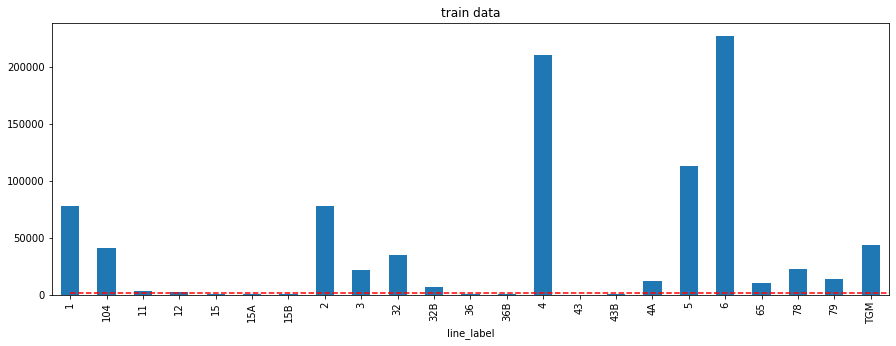

In [10]:
plt.figure(figsize=(15,5))
X_train.groupby('line_label').sequence_id.count().plot(kind = 'bar')
plt.plot(np.arange(31), np.ones(31)*1000, 'r--')
plt.title('train data')
plt.show()

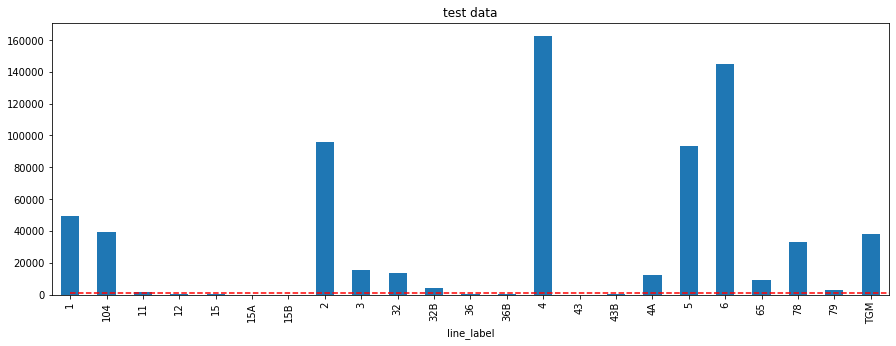

In [11]:
plt.figure(figsize=(15,5))
X_test.groupby('line_label').sequence_id.count().plot(kind = 'bar')
plt.plot(np.arange(31), np.ones(31)*1000, 'r--')
plt.title('test data')
plt.show()

In [12]:
#scale data
#min max scaler
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
encoder = LabelEncoder()

encoder.fit(data[['line_label']])
X_train.line_label = encoder.transform(X_train.line_label)
X_test.line_label  = encoder.transform(X_test.line_label)

C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [13]:
X_train = X_train.drop('sequence_id', axis=1).values
X_test = X_test.drop('sequence_id', axis=1).values

In [14]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [15]:
X_train.shape

(919349, 19)

In [16]:
X_test.shape

(717310, 19)

In [17]:
y_train = y_train.values.reshape(-1,1)
y_test  = y_test.values.reshape(-1,1)

In [18]:
X_train = X_train.reshape(-1,1,19)
X_test = X_test.reshape(-1,1,19)

In [19]:
X_train.shape

(919349, 1, 19)

In [20]:
X_test.shape

(717310, 1, 19)

In [21]:
y_train.shape

(919349, 1)

In [22]:
y_test.shape

(717310, 1)

## GRU one to one

In [66]:
from kerastuner import RandomSearch , Hyperband , BayesianOptimization
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.data import Dataset
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [81]:
#model architecture keras API

def generate_model(hp=None):
    #default hyper parameters
    num_stacked_gru   = 1
    num_stacked_dense = 2
    droput_rate       = 0.2
    gru_units         = 128
    dense_units       = 256
    learning_rate     = 0.003
    
    if hp:
        num_stacked_gru   = hp.Choice('num_stacked_gru', values=[0, 1])
        num_stacked_dense = hp.Choice('num_stacked_dense', values=[0, 1, 2, 3])
        droput_rate       = hp.Float('droput_rate', min_value=0.2 , max_value=0.5)
        learning_rate     = hp.Float('learning_rate', min_value=0.001, max_value=0.01)
        gru_units         = hp.Int('gru_units', min_value=64, max_value=256, step=32)
        dense_units       = hp.Int('dense_units', min_value=128, max_value=256, step=32)

    #one time step
    ts = layers.Input(shape = (1,19))
    
    #GRU layers Block
    if num_stacked_gru > 0 :
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, 1, 19), return_sequences=True )(ts)
        for i in range(num_stacked_gru):
            if i+1 == num_stacked_gru:
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=False )(x)
            else:
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=True )(x)
    else : 
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, 1, 19), return_sequences=False )(ts)

    #Dense layers block
    for i in range(num_stacked_dense):
        x = layers.Dense(dense_units, activation='relu')(x)
        x = layers.Dropout(droput_rate)(x)
    out = layers.Dense(1, activation='relu')(x)
    
    #build model
    model = Model(ts, out)

    #model compilation
    optimizer = Adam(lr=learning_rate)
    loss = MeanSquaredError()
    metric = RootMeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)

    return model

In [83]:
#tensorflow data pipeline 
dataset = Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(256)
train_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset = Dataset.from_tensor_slices((X_test, y_test))
dataset = dataset.batch(256)
test_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [84]:
tuner = BayesianOptimization(
    generate_model,
    objective = kerastuner.Objective("val_root_mean_squared_error", direction="min"),
    max_trials = 20,
    directory = './tuner',
    project_name = 'travel_time',
    overwrite = True
)

In [85]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_stacked_gru (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
num_stacked_dense (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
droput_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': None}
gru_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}


In [ ]:
tuner.search(train_data, validation_data=test_data, epochs=30, verbose=True,
             callbacks=[EarlyStopping(restore_best_weights=True, patience=3, monitor='val_root_mean_squared_error')])

Trial 14 Complete [00h 07m 48s]
val_root_mean_squared_error: 76.63070678710938

Best val_root_mean_squared_error So Far: 67.53700256347656
Total elapsed time: 02h 35m 10s


C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "



Search: Running Trial #15

Hyperparameter    |Value             |Best Value So Far 
num_stacked_gru   |0                 |1                 
num_stacked_dense |0                 |2                 
droput_rate       |0.40093           |0.25615           
learning_rate     |0.0090126         |0.0047542         
gru_units         |192               |160               
dense_units       |192               |192               

Epoch 1/30
3592/3592 [==============================] - 33s 9ms/step - loss: 12598.0698 - root_mean_squared_error: 111.5425 - val_loss: 11458.2227 - val_root_mean_squared_error: 107.0431
Epoch 2/30
3592/3592 [==============================] - 30s 8ms/step - loss: 10674.9348 - root_mean_squared_error: 103.2223 - val_loss: 10648.4062 - val_root_mean_squared_error: 103.1911
Epoch 3/30
3592/3592 [==============================] - 29s 8ms/step - loss: 9795.2793 - root_mean_squared_error: 98.8909 - val_loss: 9921.9150 - val_root_mean_squared_error: 99.6088
Epoch 4/30
3592

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [120]:
loss, rmse = model.evaluate(test_data)
print('test loss : {:.2f}    test rmse : {:.2f} '.format(loss, rmse))

2802/2802 [==============================] - 11s 4ms/step - loss: 4399.7505 - root_mean_squared_error: 66.3306
test loss : 4399.75    test rmse : 66.33 


In [121]:
y_pred = model.predict(X_test)

In [122]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rsquared : ', r2_score(y_test,y_pred))
print('test rmse     : ', np.sqrt(mean_squared_error(y_test,y_pred)))

test rsquared :  0.6265663674921599
test rmse     :  66.33063437219165


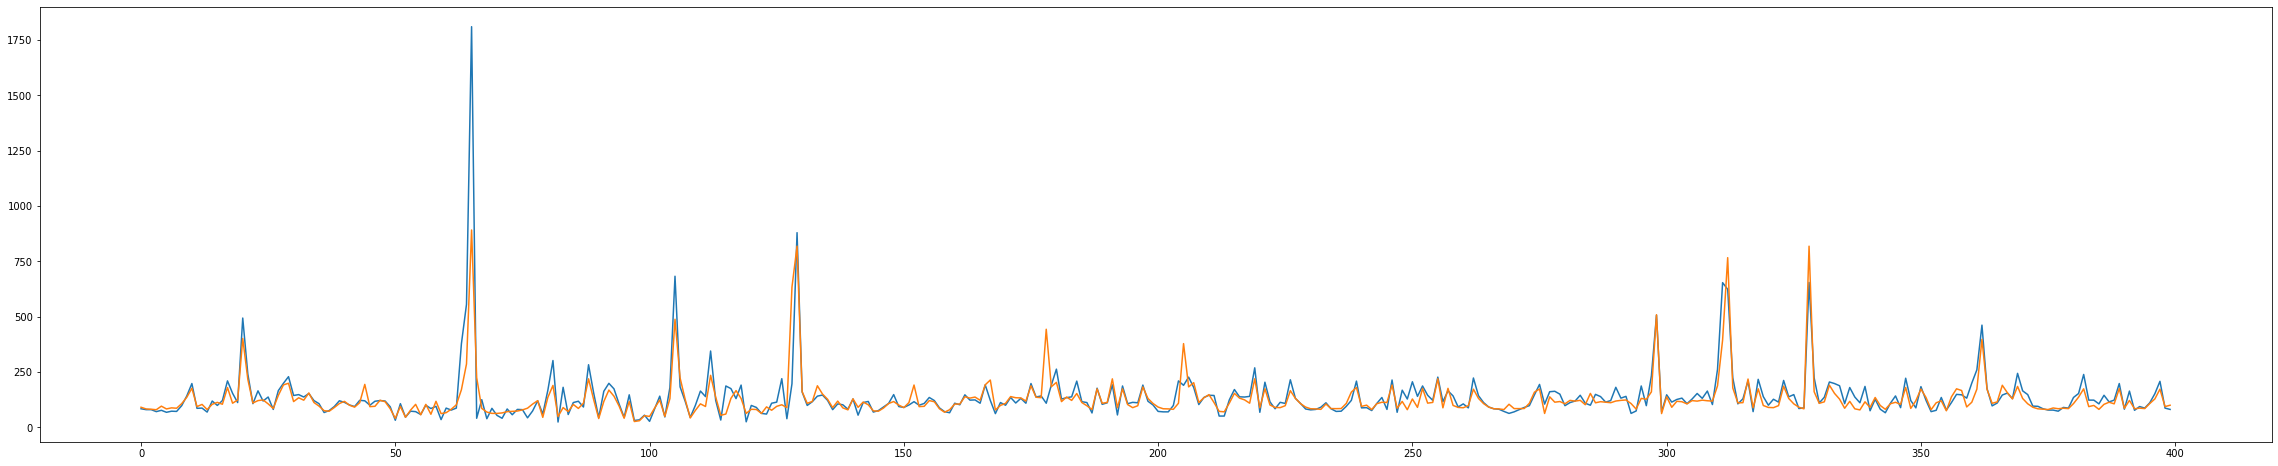

In [123]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [62]:
#export model
model.save_weights('checkpoint/one_to_one.cpkt')

## GRU Many To One : 3 time step window

In [24]:
from kerastuner import RandomSearch , Hyperband , BayesianOptimization
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [9]:
#add Time series cross validation
#try autoEncoders
#keras tuner : done
#model stacking, ensembling : on going (combination of keras tuner best models)
#pretrained models : canceled
#different timesteps : on going
#seq to seq model : no need for such model

In [10]:
train.columns

Index(['vehicle_id', 'line_id', 'datetime', 'station_id', 'vehicle_type',
       'sequence_id', 'order', 'line_label', 'datetime_diff', 'outlier',
       'hour', 'quarter', 'weekday', 'service_class', 'Temperature',
       'Precipitation', 'Wind Speed', 'Visibility', 'Cloud Cover',
       'Relative Humidity', 'Conditions', 'distance_diff',
       'distance_traveled'],
      dtype='object')

In [11]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoder = LabelEncoder()

encoder.fit(data[['line_label']])
train.line_label = encoder.transform(train.line_label)
test.line_label  = encoder.transform(test.line_label)

C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
train.drop(['outlier','datetime'], axis=1, inplace=True)
test.drop(['outlier','datetime'], axis=1, inplace=True)

C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
scaler = MinMaxScaler()
scaler_notarget = MinMaxScaler()

scaler.fit(train.drop(['sequence_id'], axis=1) )
scaler_notarget.fit(train.drop(['sequence_id','datetime_diff'], axis=1) );

In [14]:
train_input_X1 = scaler.transform(train.groupby('sequence_id',dropna=False).shift(2).fillna(-1))
train_input_X2 = scaler.transform(train.groupby('sequence_id',dropna=False).shift(1).fillna(-1))
train_input_X3 = scaler_notarget.transform(train.drop(['sequence_id', 'datetime_diff'], axis=1).fillna(-1))

In [15]:
test_input_X1 = scaler.transform(test.groupby('sequence_id',dropna=False).shift(2).fillna(-1))
test_input_X2 = scaler.transform(test.groupby('sequence_id',dropna=False).shift(1).fillna(-1))
test_input_X3 = scaler_notarget.transform(test.drop(['sequence_id', 'datetime_diff'], axis=1).fillna(-1))

In [ ]:
#targets
y_train = train[['datetime_diff']].values
y_test = test[['datetime_diff']].values

In [ ]:
#3 time steps train features
train_input_X1 = train_input_X1.reshape(-1,1,20)
train_input_X2 = train_input_X2.reshape(-1,1,20)
train_input_X3 = train_input_X3.reshape(-1,1,19)

In [ ]:
#3 time steps test features
test_input_X1 = test_input_X1.reshape(-1,1,20)
test_input_X2 = test_input_X2.reshape(-1,1,20)
test_input_X3 = test_input_X3.reshape(-1,1,19)

In [135]:
#model architecture keras API

def generate_model(hp=None):
    #default hyper parameters
    num_stacked_dense = 1
    droput_rate       = 0.2
    gru_units         = 128
    dense_units       = 256
    learning_rate     = 0.003
    
    if hp:
        num_stacked_dense = hp.Choice('num_stacked_dense', values=[0, 1, 2, 3])
        droput_rate       = hp.Float('droput_rate', min_value=0.1 , max_value=0.5)
        learning_rate     = hp.Float('learning_rate', min_value=0.001, max_value=0.01)
        gru_units         = hp.Int('gru_units', min_value=64, max_value=256, step=32)
        dense_units       = hp.Int('dense_units', min_value=128, max_value=256, step=32)

    #three time step inputs
    ts1 = layers.Input(shape = (1,20))
    ts2 = layers.Input(shape = (1,20))
    ts3 = layers.Input(shape = (1,19))

    #hidden standraizers layers
    std_ts1 = layers.Dense(19, activation = 'linear')(ts1)
    std_ts2 = layers.Dense(19, activation = 'linear')(ts2)
    #concatenate time step features in order
    x  = layers.concatenate([std_ts1, std_ts2, ts3], axis = 1)
    
    #GRU (3 time steps)
    x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, 3, 19), return_sequences=True )(x)
   
    #Dense layers block
    for i in range(num_stacked_dense):
        x = layers.Dense(dense_units, activation='relu')(x)
        x = layers.Dropout(droput_rate)(x)
    out = layers.Dense(1, activation='relu')(x)
    
    #build model
    model = Model([ts1, ts2, ts3], out)
    #model compilation
    optimizer = Adam(lr=learning_rate)
    loss = MeanSquaredError()
    metric = RootMeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)

    return model

In [138]:
#tensorflow data pipeline 
dataset = Dataset.from_tensor_slices(((train_input_X1, train_input_X2, train_input_X3), y_train))
dataset = dataset.batch(256)
train_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset = Dataset.from_tensor_slices(((test_input_X1, test_input_X2, test_input_X3), y_test))
dataset = dataset.batch(256)
test_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [84]:
tuner = BayesianOptimization(
    generate_model,
    objective = kerastuner.Objective("val_root_mean_squared_error", direction="min"),
    max_trials = 20,
    directory = './tuner',
    project_name = 'travel_time_mto',
    overwrite = True
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_data, validation_data=test_data, epochs=30, verbose=True,
             callbacks=[EarlyStopping(restore_best_weights=True, patience=3, monitor='val_root_mean_squared_error')])

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [140]:
loss, rmse = model.evaluate(test_data)
print('test loss : {:.2f}    test rmse : {:.2f} '.format(loss, rmse))

2802/2802 [==============================] - 15s 5ms/step - loss: 4519.8516 - root_mean_squared_error: 67.2298
test loss : 4519.85    test rmse : 67.23 


In [141]:
y_pred = model.predict(test_data)

In [142]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rsquared : ', r2_score(y_test,y_pred))

test rsquared :  0.61637303519126


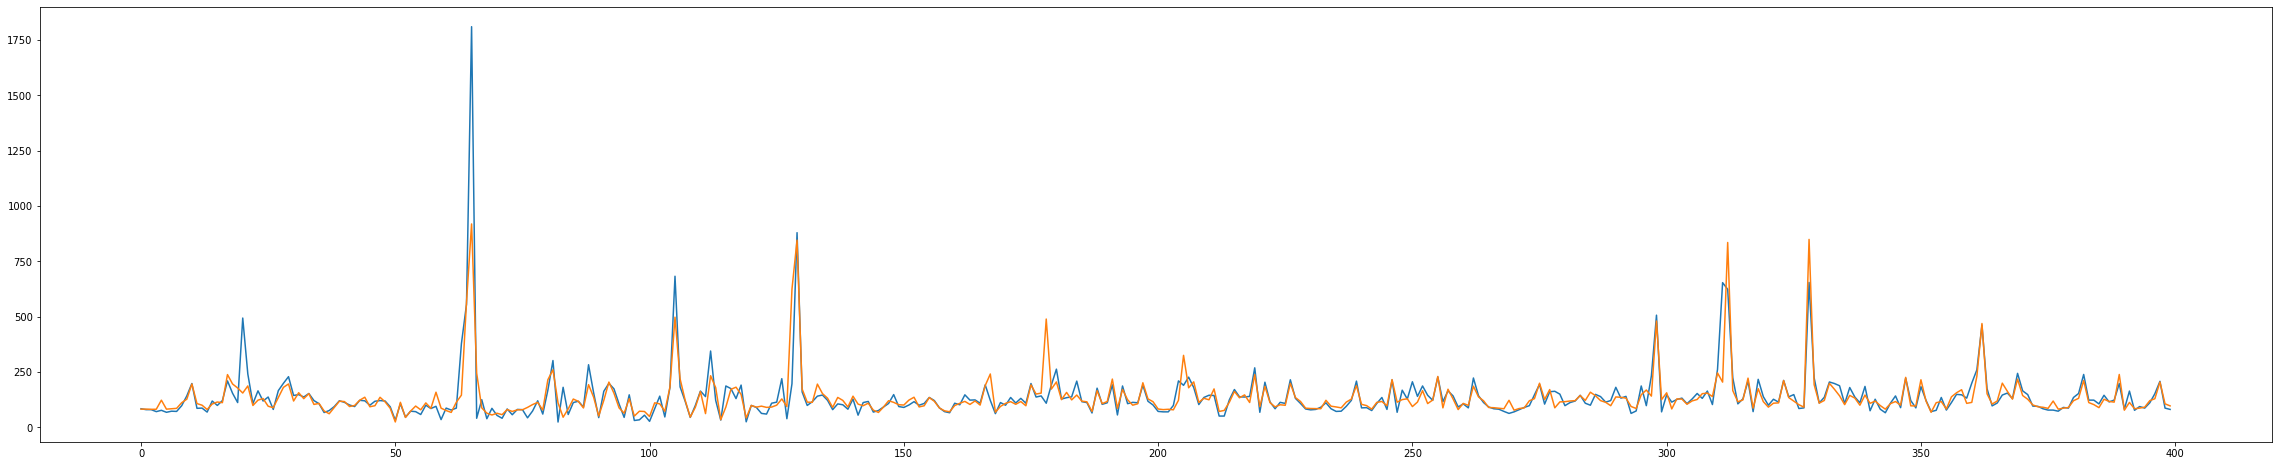

In [143]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [49]:
#export model
model.save_weights('./checkpoint/Many_to_one.cpkt')

### Prediction and tolerence Intervals : 

In [191]:
import scipy
import random

In [29]:
model.load_weights('./checkpoint/Many_to_one.cpkt');

In [30]:
y_pred = model.predict(test_data)

In [31]:
epsilon = (y_test - y_pred)

In [32]:
epsilon = epsilon.reshape(-1)
epsilon.shape

(717310,)

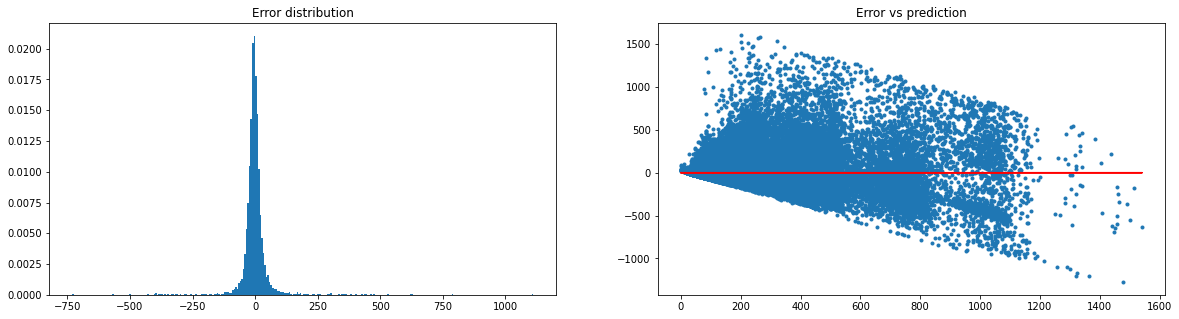

In [204]:
fig, axs = plt.subplots(1, 2, figsize = (20,5) )
axs[0].set_title('Error distribution')
_, bins, _ = axs[0].hist(sample, bins=300, density = True)
axs[1].set_title('Error vs prediction')
axs[1].plot(y_pred, epsilon, '.')
axs[1].plot(y_pred, np.zeros(y_pred.shape[0]), 'r-')

plt.show()

In [200]:
sample = random.sample(epsilon.reshape(-1,).tolist(), 4000)

In [201]:
scipy.stats.shapiro(sample)

ShapiroResult(statistic=0.5538869500160217, pvalue=0.0)

showing the histogram, we can intuitively make the hypothesis that the error distribution follows a normal distribtion <br>
If this hypothesis is correct, we can easily extract a prediction interval using the gaussian statistics table. <br>
Unfortenuatly, the shapiro test reject the null hypothesis. thus, we need first to estimate a kernel density for the error distribution, then we use the 5th and 95th kernel density percentiles to extract the prediction intervals. <br>
we can also use a straitforward emperical approach by extracting the 5th and 95th percentiles emperically from the error distrivution since we are in possession of a huge amount of data. or we can apply the bootstraping prediction interval approach using montecarlo simulation.

#### Emperical method : 

In [238]:
lower = np.percentile(epsilon, 5)
upper = np.percentile(epsilon, 95)

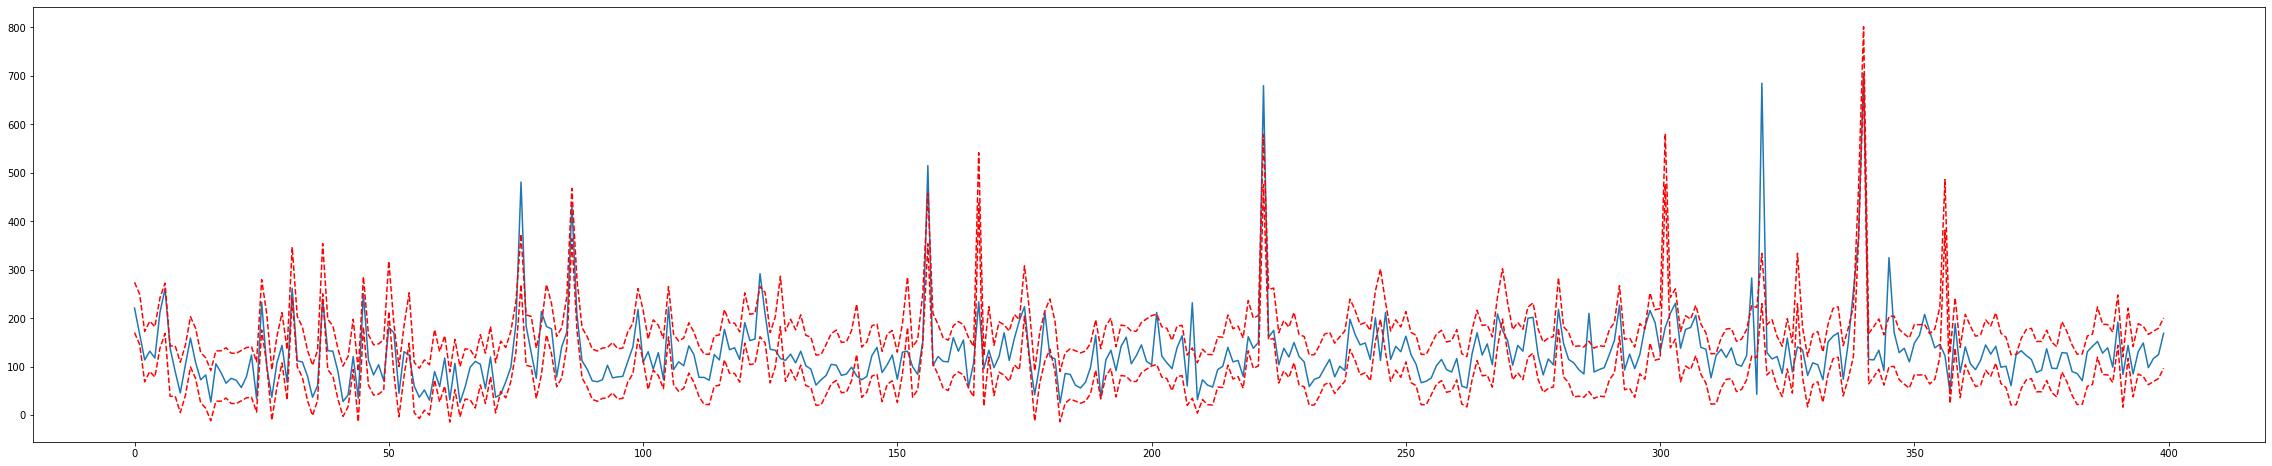

In [239]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[1000:1400].shape[0]), y_test[1000:1400])
plt.plot(np.arange(y_test[1000:1400].shape[0]), y_pred[1000:1400] + lower, 'r--')
plt.plot(np.arange(y_test[1000:1400].shape[0]), y_pred[1000:1400] + upper, 'r--')

#plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [240]:
in_boundries = y_pred[((y_pred + lower) < y_test) & ((y_pred + upper) > y_test)].shape[0]

In [241]:
all_inputs = y_pred.shape[0]

In [242]:
in_boundries*100 / all_inputs

89.99986059026084

#### Novel approach : Kernel Mixture Networks method

#### Bootstraping prediction interval method : 

#### Prediction interval methods Evaluation : 

#### Tolerence interval : 90%